In [82]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(), '..'))
import pickle


# Load the dataloaders
train_dataloader = pickle.load(open(os.path.join(os.getcwd(), '..', "data", "pytorch_data", 'train_dataloader.pkl'), 'rb'))
val_dataloader = pickle.load(open(os.path.join(os.getcwd(), '..', "data", "pytorch_data", 'val_dataloader.pkl'), 'rb'))
test_dataloader = pickle.load(open(os.path.join(os.getcwd(), '..', "data", "pytorch_data", 'test_dataloader.pkl'), 'rb'))

for team_input, player_input, ball_input, labels, mask in train_dataloader:
    print(f"Team input shape: {team_input.shape}")  # [batch_size, team_feature_dim]
    print(f"Player input shape: {player_input.shape}")  # [batch_size, player_feature_dim]
    print(f"Padded ball input shape: {ball_input.shape}")  # [batch_size, max_seq_len, ball_feature_dim]
    print(f"Mask shape: {mask.shape}")  # [batch_size, max_seq_len]
    print(f"Labels shape: {labels.shape}")  # [batch_size]
    break

Team input shape: torch.Size([32, 13])
Player input shape: torch.Size([32, 22, 11])
Padded ball input shape: torch.Size([32, 258, 10])
Mask shape: torch.Size([32, 258])
Labels shape: torch.Size([32])


Sample 6
1.0


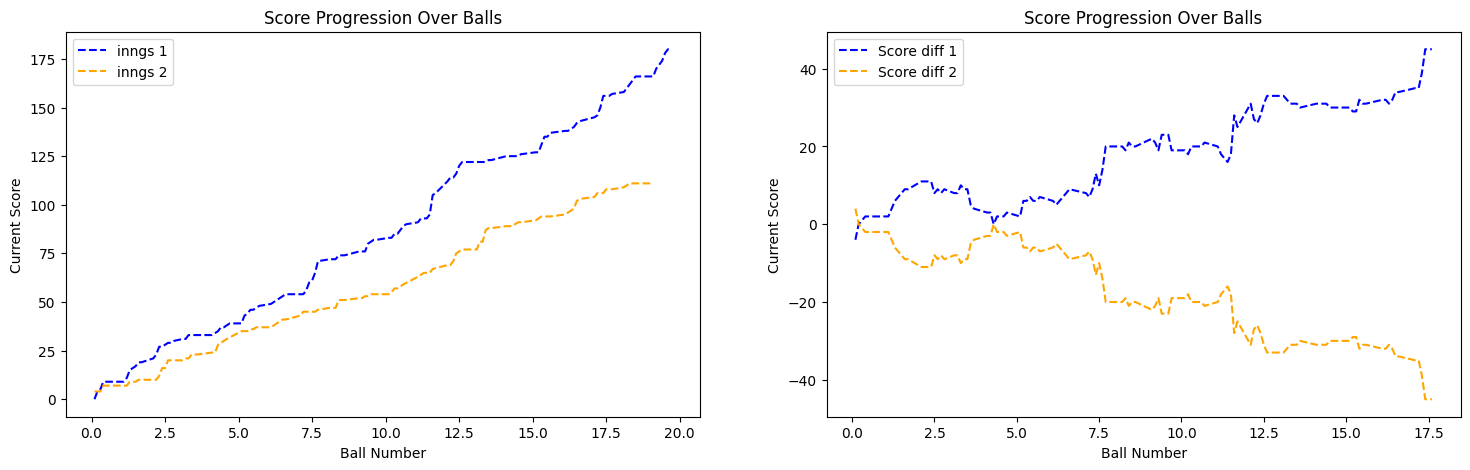

In [83]:
import matplotlib.pyplot as plt
import polars as pl
import numpy as np

i= np.random.randint(0, len(labels))
print(f"Sample {i}")
data = pl.DataFrame(ball_input[i].numpy(),schema=["innings","ball","runs","wickets","curr_score","curr_wickets","overs","run_rate","required_run_rate","target"])
label = labels[i].numpy()
print(label)
innings1 = data.filter(data['innings'] == 1)
innings2 = data.filter(data['innings'] == 2)

# Visualize the progression of score over balls
fig,[ax1,ax2] = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))
ax1.plot(innings1.to_pandas()["ball"], innings1.to_pandas()["curr_score"], linestyle="--", color="blue", label="inngs 1")
ax1.plot(innings2.to_pandas()["ball"], innings2.to_pandas()["curr_score"], linestyle="--", color="orange", label="inngs 2")

ax1.set_title("Score Progression Over Balls")
ax1.set_xlabel("Ball Number")
ax1.set_ylabel("Current Score")
ax1.legend()

diff1 = innings1.to_pandas()["curr_score"] - innings2.to_pandas()["curr_score"]
diff2 = innings2.to_pandas()["curr_score"] - innings1.to_pandas()["curr_score"]
min_length = min(len(diff1), len(diff2))
ax2.plot(innings1.to_pandas()["ball"][:min_length], diff1[:min_length], linestyle="--", color="blue", label="Score diff 1")
ax2.plot(innings1.to_pandas()["ball"][:min_length], diff2[:min_length], linestyle="--", color="orange", label="Score diff 2")
ax2.set_title("Score Progression Over Balls")
ax2.set_xlabel("Ball Number")
ax2.set_ylabel("Current Score")
ax2.legend()  
plt.show()

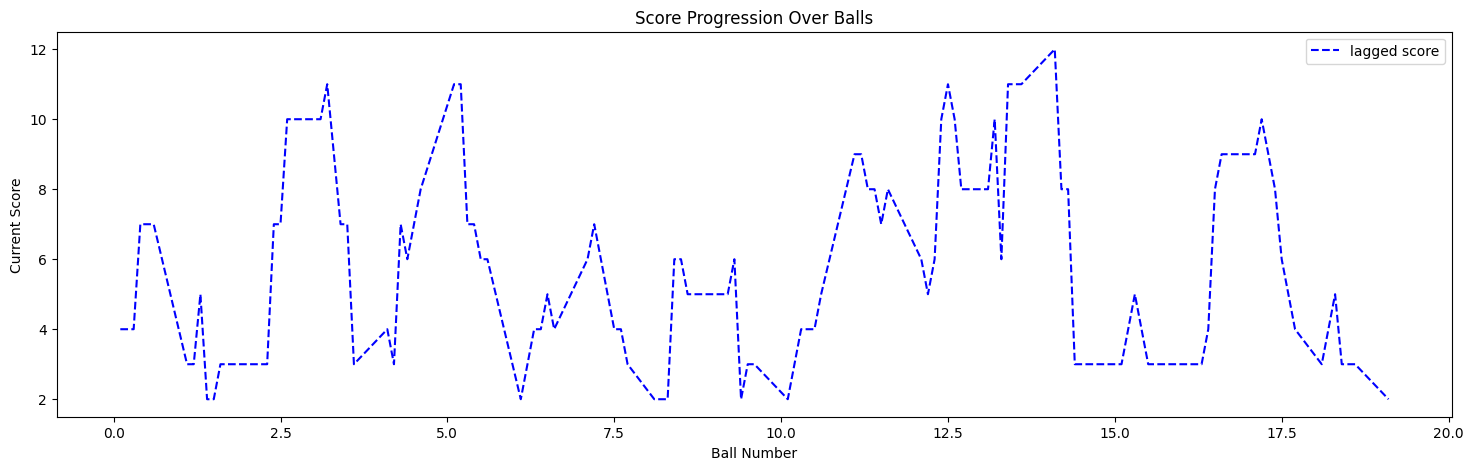

In [86]:
# lags = 6

lagged_data = innings2.shift(6).fill_null(0)
lg = innings2-lagged_data

# plot lags
fig, ax = plt.subplots(figsize=(18, 5))
ax.plot(innings2.to_pandas()["ball"], lg.to_pandas()["curr_score"], linestyle="--", color="blue", label="lagged score")
ax.set_title("Score Progression Over Balls")
ax.set_xlabel("Ball Number")
ax.set_ylabel("Current Score")
ax.legend()
plt.show()

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  112
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -220.294
Date:                Mon, 18 Nov 2024   AIC                            452.588
Time:                        01:14:22   BIC                            468.845
Sample:                             0   HQIC                           459.183
                                - 112                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0814      0.131     -0.622      0.534      -0.338       0.175
ar.L2          0.0947      0.103      0.918      0.359      -0.108       0.297
ar.L3         -0.0593      0.121     -0.489      0.6

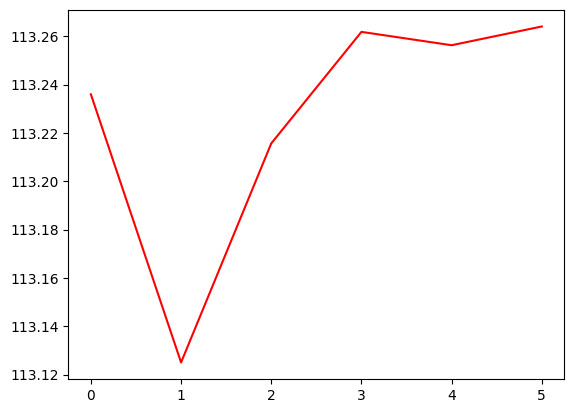

In [92]:
# train the model arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# load dataset
series = innings2.to_pandas()["curr_score"]
# prepare data
X = series.values
X = X.astype('float32')

# difference data
diff = difference(X, interval=6)
# fit model
model = ARIMA(diff, order=(5,1,0))
model_fit = model.fit()
print(model_fit.summary())
# forecast
forecast = model_fit.forecast(steps=6)
# invert forecast
forecast = [inverse_difference(X, yhat) for yhat in forecast]
# print forecast
print(forecast)
# plot forecast
plt.plot(forecast, color="red")
plt.show()